## Modeling Objetives

### Introduction

After doing the data cleaning and feature selection. We have decided to test models in order to either predict the average ratings of a book or by doing a classification of the book using engineered features.
It would be interesting too to compare models that predict the initial average rating, when using SMOTE algorithm in order to balance the data.

## Steps to follow

#### 1. Preparing the dataset for regression



In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
#dataset = pd.read_excel('Projet Python simulations.xlsx',sheet_name="Python_Dataset")


In [27]:
# We load the dataset and we check the content and the columns
clean_dataset = pd.read_csv('clean_dataset.csv')
display(clean_dataset.columns)
clean_dataset.head()


Index(['Unnamed: 0', 'bookid', 'title', 'authors', 'average_rating', 'isbn',
       'isbn13', 'language_code', 'num_pages', 'ratings_count',
       'text_reviews_count', 'publication_date', 'publisher', 'title2',
       'author2', 'genre', 'multiple_authors', 'n_authors', 'authors_list',
       'main_author', 'ratings_count_updt', 'text_reviews_count_updt',
       'max_pages', 'total_reviews', 'avg_numpages_author',
       'n_pages_vs_avg_auth', 'avg_numpages_publisher', 'n_pages_vs_avg_pub',
       'avg_rating_author', 'rating_vs_avg_auth', 'avg_rating_publisher',
       'rating_vs_avg_pub', 'rating_vs_avg', 'rating_vs_mode', 'pub_month',
       'pub_year', 'pub_month_text', 'season', 'season_num', 'century',
       'language_code_ENgroup', 'log_ratings_count', 'ratings_count_category',
       'ratings_count_category_T', 'log_text_reviews_count_updt',
       'text_reviews_count_category', 'text_reviews_count_category_T',
       'log_total_reviews', 'total_reviews_category',
       'to

,Unnamed: 0,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,...,language_code_ENgroup_T,genre_T,num_pages_cat,max_pages_cat,num_pages_cat_T,max_pages_cat_T,average_rating_cat,average_rating_cat_T,average_rating_three_cat,average_rating_three_cat_T
0,1847,6549,said the shotgun to the head.,saul williams,4.22,0743470796,9780743470797,en-us,192,2762,...,7057,59595,low,low,2,2,good,4,high,3.0
1,4072,14490,$30 film school: how to write direct produce...,michael w. dean,3.49,1592000673,9781592000678,eng,528,30,...,7057,70172,high,high,4,4,medium,3,low,1.0
2,1574,5415,'salem's lot,stephen king,4.02,0965772411,9780965772419,eng,405,1039,...,7057,73245,high,high,4,4,good,4,medium,2.0
3,3137,11525,1 000 places to see before you die,patricia schultz,3.85,0761104844,9780761104841,eng,992,36303,...,7057,58063,high,high,4,4,good,4,medium,2.0
4,2343,8542,10 lb penalty,dick francis,3.90,042519745X,9780425197455,eng,320,3490,...,7057,80651,medium,medium,3,3,good,4,medium,2.0


In [37]:
# We will only choose numerical data that is not a transformation using the average ratings and we avoid highly correlated variables
regression_columns = ['average_rating','log_ratings_count', 'log_total_reviews','multiple_authors', 'n_authors', 'max_pages', 'season_num','average_rating_three_cat_T']
regression_dataset = clean_dataset[regression_columns]
regression_dataset = regression_dataset[~(regression_dataset['average_rating_three_cat_T'].isna())]
display(regression_dataset.head())

,average_rating,log_ratings_count,log_total_reviews,multiple_authors,n_authors,max_pages,season_num,average_rating_three_cat_T
0,4.22,3.441239,3.473648,0,1,192,4,3.0
1,3.49,1.478566,1.532754,0,1,528,2,1.0
2,4.02,4.933751,4.937909,0,1,817,4,2.0
3,3.85,4.559944,4.565164,0,1,992,2,2.0
4,3.90,3.542838,3.564323,0,1,320,3,2.0


<AxesSubplot: >

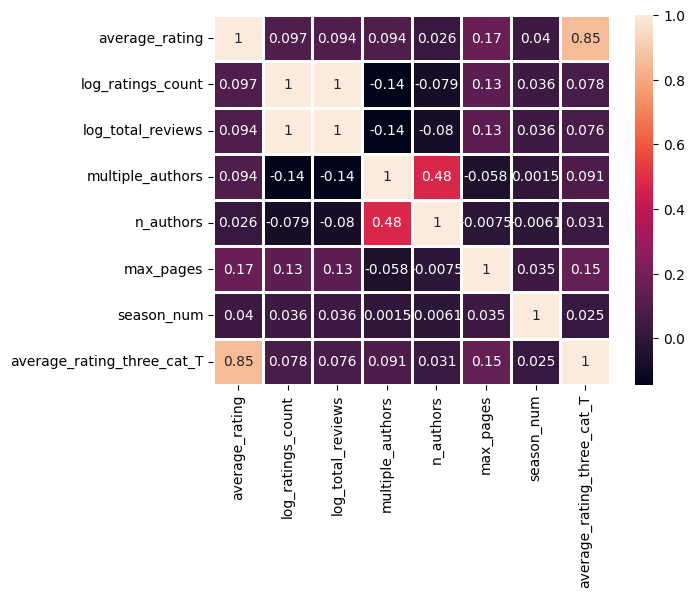

In [38]:
# We observe that average_rating and average_rating_three_cat_T are highly correlated, this is expected as the latter is a transformation of the first into a categorical variable
sns.heatmap(regression_dataset.corr(),annot=True,lw=1)

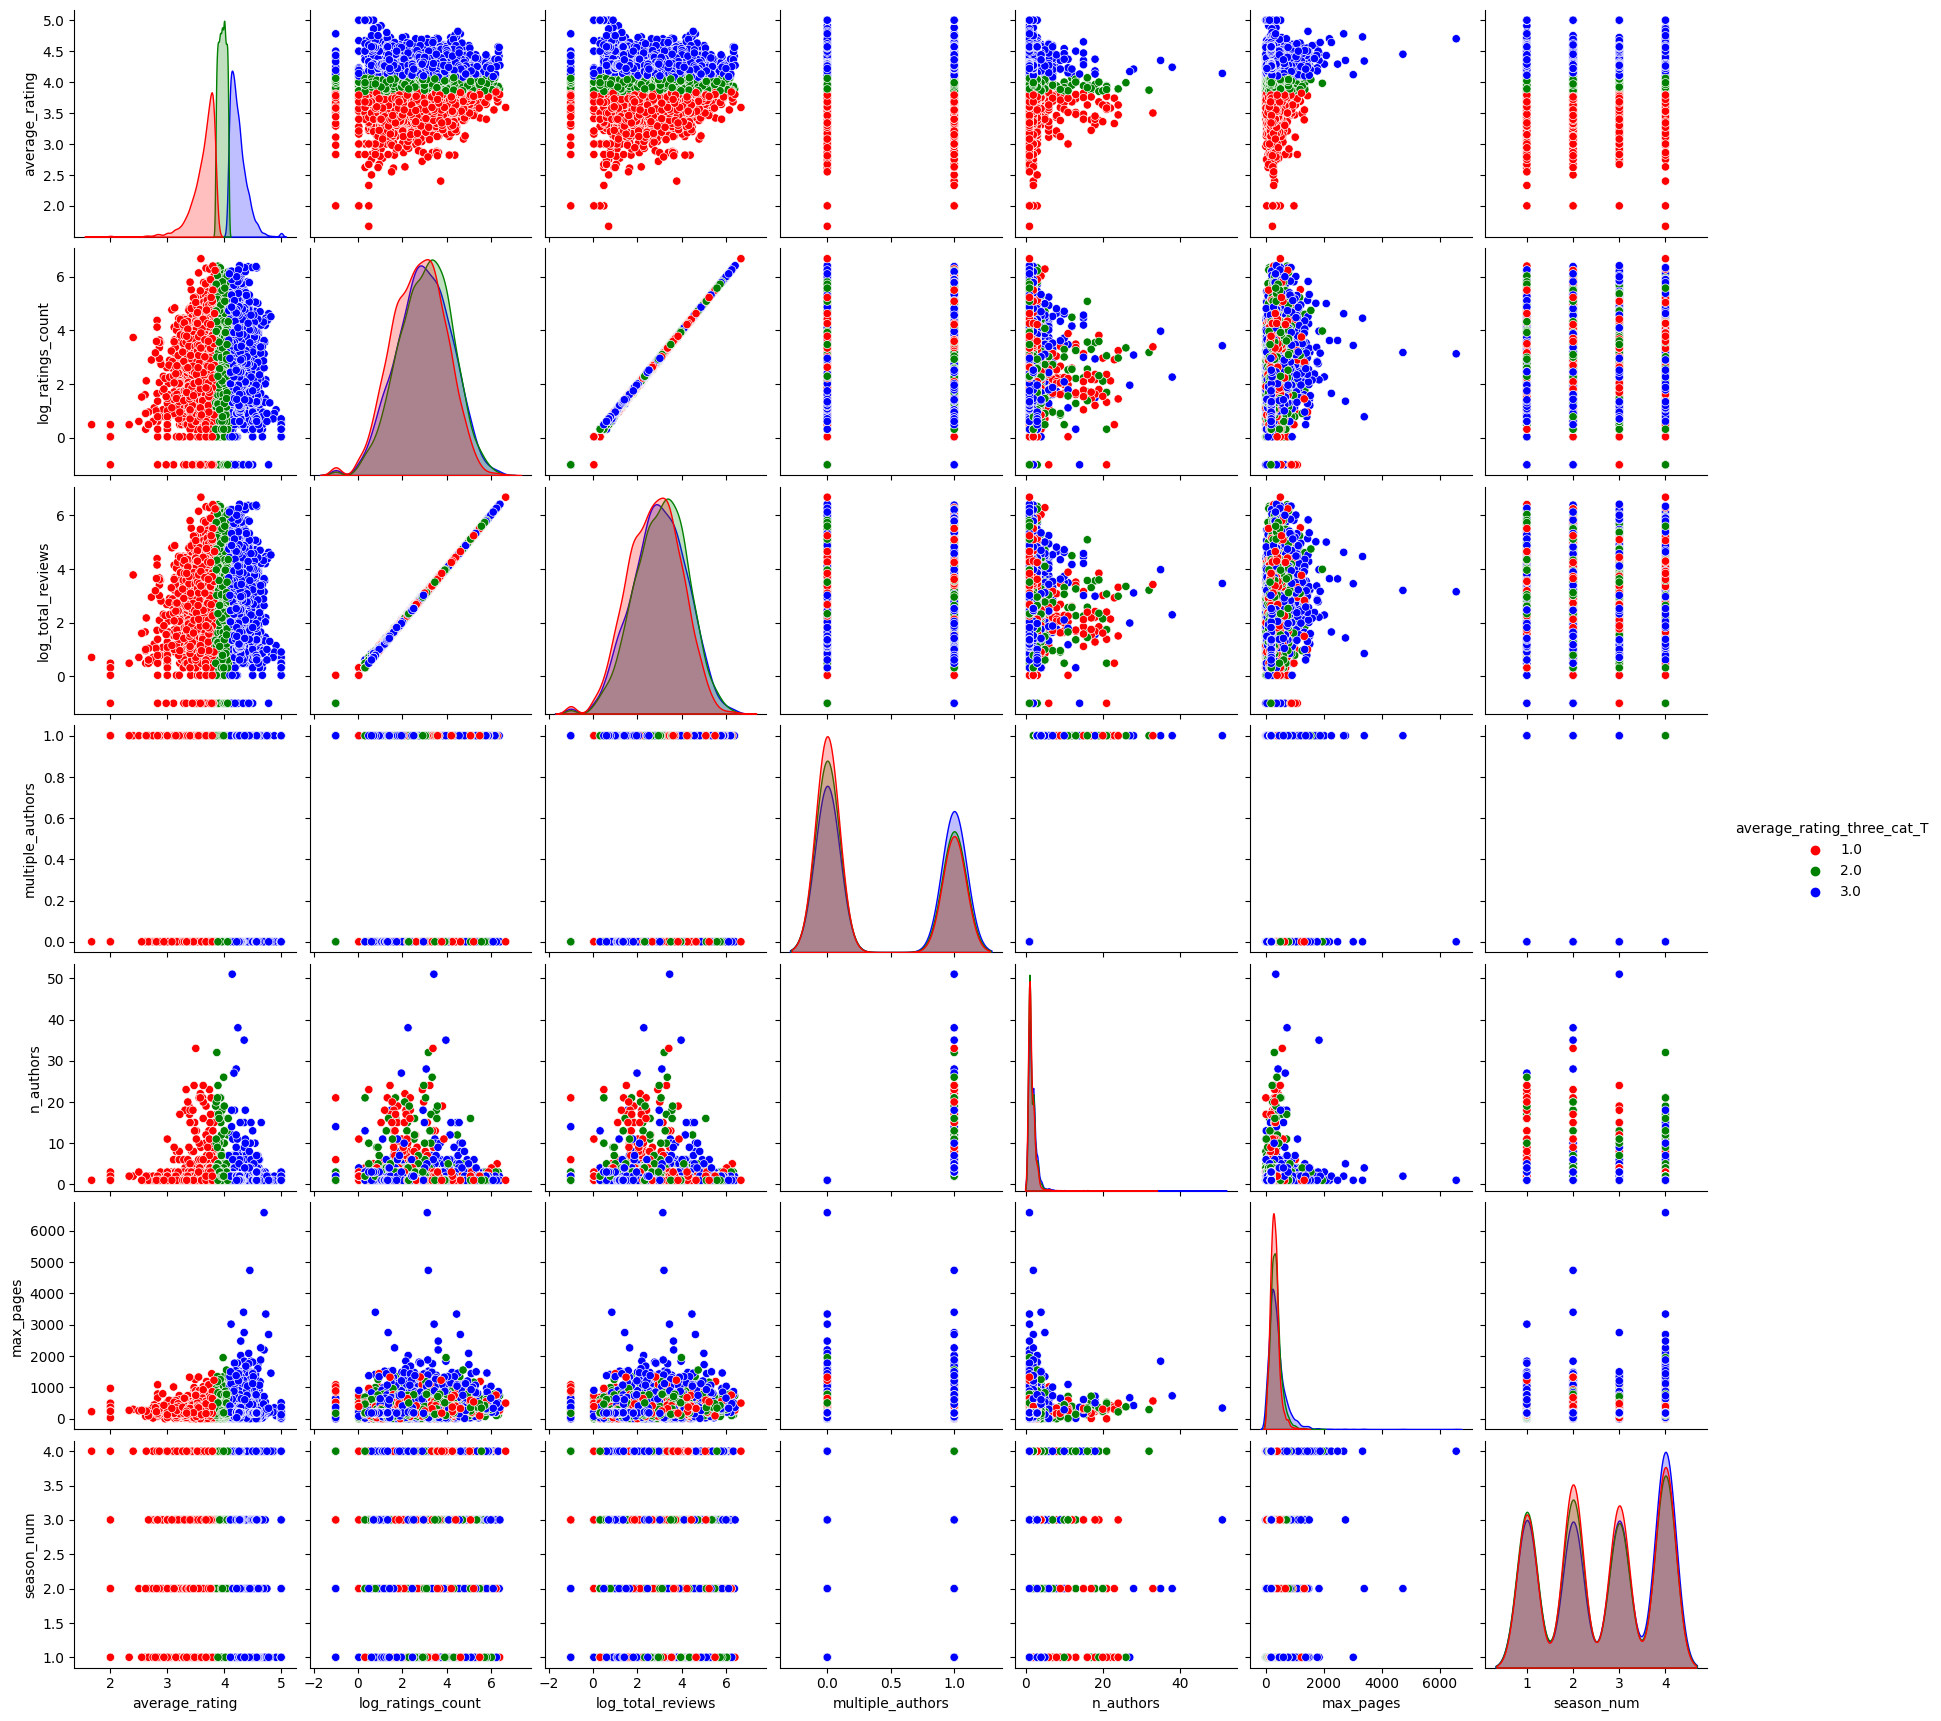

In [39]:
# We observe the distribution of each variable pair by pairs, and we observe the position of our new engineered target category
sns.pairplot(regression_dataset,hue='average_rating_three_cat_T', palette=['r', 'g', 'b'])

In [40]:
# This is a helper function that helps transform categorical data into dummies, to adapt the data for the regression
def from_categoric_to_dummies(columns,dataset):
    dummies = []
    for col in columns:
        dummies.append(pd.get_dummies(dataset[col], prefix=col, prefix_sep='_'))
    new_dataset = pd.concat([dataset, *dummies], axis=1)
    new_dataset = new_dataset.drop(columns, axis=1)
    return new_dataset

In [41]:
#we will create two datasets: one containing the average_ratings and a second containing the transformation of this target column into 3 different categories
regression_dataset_avg_rating_cat = regression_dataset.drop('average_rating', axis=1)
regression_dataset_avg_rating = regression_dataset.drop('average_rating_three_cat_T', axis=1)

In [42]:
# We generate dummies for the categories, pub_month and season_num
regression_dataset_avg_rating_cat = from_categoric_to_dummies(['season_num'],regression_dataset_avg_rating_cat)
regression_dataset_avg_rating = from_categoric_to_dummies(['season_num'],regression_dataset_avg_rating)


## 2. Generating Training and test datasets


For our project we wanted to tackle the problem of predicting the ratings the average ratings of a book from the other parameters we have taken

In [47]:
from sklearn.model_selection import train_test_split

def prepare_dataset_for_linear_regression(dataset,target_column, test_size,dataset_name):
    result = {}
    result['name'] = dataset_name
    df_train, df_test = train_test_split(dataset,test_size = test_size)
    display(len(dataset))
    display(len(df_train))
    display(len(df_test))
    display(regression_dataset.describe())
    display(df_train.describe())
    display(df_test.describe())
    X_train = df_train.drop([target_column], axis=1)
    Y_train = df_train[target_column].values
    X_test = df_test.drop([target_column], axis=1)
    Y_test = df_test[target_column].values
    result['X_train'] = X_train
    result['Y_train'] = Y_train
    result['X_test'] = X_test
    result['Y_test'] = Y_test
    return result
    

In [46]:
display(regression_dataset_avg_rating_cat.head())
display(regression_dataset_avg_rating.head())

,log_ratings_count,log_total_reviews,multiple_authors,n_authors,max_pages,average_rating_three_cat_T,season_num_1,season_num_2,season_num_3,season_num_4
0,3.441239,3.473648,0,1,192,3.0,0,0,0,1
1,1.478566,1.532754,0,1,528,1.0,0,1,0,0
2,4.933751,4.937909,0,1,817,2.0,0,0,0,1
3,4.559944,4.565164,0,1,992,2.0,0,1,0,0
4,3.542838,3.564323,0,1,320,2.0,0,0,1,0


,average_rating,log_ratings_count,log_total_reviews,multiple_authors,n_authors,max_pages,season_num_1,season_num_2,season_num_3,season_num_4
0,4.22,3.441239,3.473648,0,1,192,0,0,0,1
1,3.49,1.478566,1.532754,0,1,528,0,1,0,0
2,4.02,4.933751,4.937909,0,1,817,0,0,0,1
3,3.85,4.559944,4.565164,0,1,992,0,1,0,0
4,3.90,3.542838,3.564323,0,1,320,0,0,1,0


In [54]:
regression_dataset_avg_rating_cat_dict = prepare_dataset_for_linear_regression(regression_dataset_avg_rating_cat,'average_rating_three_cat_T',0.2,'Regression using Average Rating Category')
regression_dataset_avg_rating_dict = prepare_dataset_for_linear_regression(regression_dataset_avg_rating,'average_rating',0.2,'Regression using Average Rating Category')

10281

8224

2057

,average_rating,log_ratings_count,log_total_reviews,multiple_authors,n_authors,max_pages,season_num,average_rating_three_cat_T
count,10281.000000,10281.000000,10281.000000,10281.000000,10281.000000,10281.000000,10281.000000,10281.000000
mean,3.942800,2.908658,2.938936,0.398016,1.712966,338.565898,2.602471,1.990857
std,0.297308,1.207651,1.198812,0.489513,1.842272,239.349215,1.138737,0.819102
min,1.670000,-1.000000,-1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,3.770000,2.057286,2.100715,0.000000,1.000000,199.000000,2.000000,1.000000
50%,3.960000,2.947483,2.975937,0.000000,1.000000,301.000000,3.000000,2.000000
75%,4.140000,3.768053,3.788953,1.000000,2.000000,416.000000,4.000000,3.000000
max,5.000000,6.662537,6.671352,1.000000,51.000000,6576.000000,4.000000,3.000000


,log_ratings_count,log_total_reviews,multiple_authors,n_authors,max_pages,average_rating_three_cat_T,season_num_1,season_num_2,season_num_3,season_num_4
count,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000
mean,2.917658,2.947839,0.390199,1.713886,339.003891,1.992096,0.226046,0.242826,0.228234,0.302894
std,1.207378,1.198761,0.487825,1.905967,240.239703,0.817872,0.418295,0.428817,0.419720,0.459538
min,-1.000000,-1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.067626,2.107549,0.000000,1.000000,199.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,2.960994,2.990161,0.000000,1.000000,302.000000,2.000000,0.000000,0.000000,0.000000,0.000000
75%,3.772567,3.794913,1.000000,2.000000,416.000000,3.000000,0.000000,0.000000,0.000000,1.000000
max,6.662537,6.671352,1.000000,51.000000,6576.000000,3.000000,1.000000,1.000000,1.000000,1.000000


,log_ratings_count,log_total_reviews,multiple_authors,n_authors,max_pages,average_rating_three_cat_T,season_num_1,season_num_2,season_num_3,season_num_4
count,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000
mean,2.872673,2.903342,0.429266,1.709285,336.814779,1.985902,0.228488,0.261060,0.211959,0.298493
std,1.208365,1.198644,0.495092,1.562285,235.805025,0.824182,0.419961,0.439319,0.408795,0.457708
min,-1.000000,-1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.037825,2.075912,0.000000,1.000000,196.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,2.880871,2.905310,0.000000,1.000000,299.000000,2.000000,0.000000,0.000000,0.000000,0.000000
75%,3.743988,3.766792,1.000000,2.000000,412.000000,3.000000,0.000000,1.000000,0.000000,1.000000
max,6.384831,6.388766,1.000000,32.000000,3400.000000,3.000000,1.000000,1.000000,1.000000,1.000000


10281

8224

2057

,average_rating,log_ratings_count,log_total_reviews,multiple_authors,n_authors,max_pages,season_num,average_rating_three_cat_T
count,10281.000000,10281.000000,10281.000000,10281.000000,10281.000000,10281.000000,10281.000000,10281.000000
mean,3.942800,2.908658,2.938936,0.398016,1.712966,338.565898,2.602471,1.990857
std,0.297308,1.207651,1.198812,0.489513,1.842272,239.349215,1.138737,0.819102
min,1.670000,-1.000000,-1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,3.770000,2.057286,2.100715,0.000000,1.000000,199.000000,2.000000,1.000000
50%,3.960000,2.947483,2.975937,0.000000,1.000000,301.000000,3.000000,2.000000
75%,4.140000,3.768053,3.788953,1.000000,2.000000,416.000000,4.000000,3.000000
max,5.000000,6.662537,6.671352,1.000000,51.000000,6576.000000,4.000000,3.000000


,average_rating,log_ratings_count,log_total_reviews,multiple_authors,n_authors,max_pages,season_num_1,season_num_2,season_num_3,season_num_4
count,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000
mean,3.941262,2.902073,2.932667,0.400049,1.727626,338.128040,0.225559,0.244528,0.228113,0.301800
std,0.297155,1.212553,1.203594,0.489938,1.900795,243.266742,0.417976,0.429833,0.419641,0.459067
min,1.670000,-1.000000,-1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,3.770000,2.049606,2.097257,0.000000,1.000000,196.000000,0.000000,0.000000,0.000000,0.000000
50%,3.960000,2.927935,2.959566,0.000000,1.000000,299.000000,0.000000,0.000000,0.000000,0.000000
75%,4.140000,3.767033,3.787379,1.000000,2.000000,414.000000,0.000000,0.000000,0.000000,1.000000
max,5.000000,6.662537,6.671352,1.000000,51.000000,6576.000000,1.000000,1.000000,1.000000,1.000000


,average_rating,log_ratings_count,log_total_reviews,multiple_authors,n_authors,max_pages,season_num_1,season_num_2,season_num_3,season_num_4
count,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000
mean,3.948950,2.934984,2.964002,0.389888,1.654351,340.316480,0.230433,0.254254,0.212445,0.302868
std,0.297909,1.187777,1.179453,0.487843,1.585937,223.047873,0.421212,0.435547,0.409138,0.459610
min,2.000000,-1.000000,-1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,3.780000,2.079543,2.120903,0.000000,1.000000,206.000000,0.000000,0.000000,0.000000,0.000000
50%,3.960000,3.001344,3.031045,0.000000,1.000000,304.000000,0.000000,0.000000,0.000000,0.000000
75%,4.140000,3.776491,3.792189,1.000000,2.000000,416.000000,0.000000,1.000000,0.000000,1.000000
max,5.000000,6.403274,6.408878,1.000000,33.000000,3020.000000,1.000000,1.000000,1.000000,1.000000


In [49]:
regression_dataset_avg_rating_cat_dict

{'name': 'regression_dataset_avg_rating_cat',
 'X_train':        log_ratings_count  log_total_reviews  multiple_authors  n_authors  \
 8430            2.000434           2.053463                 1          2   
 4132            1.432969           1.432969                 1          2   
 4104            4.593797           4.605554                 1          3   
 320             3.324920           3.360612                 1          2   
 3010            2.309843           2.346549                 0          1   
 ...                  ...                ...               ...        ...   
 6488            2.993480           3.020403                 0          1   
 7479            3.917931           3.955500                 0          1   
 5291            2.919130           2.954291                 0          1   
 10179           2.250664           2.305566                 0          1   
 3774            2.840796           2.867526                 1          2   
 
        max_pages

## Regression Algorithms

For Prediction of a variable

1. Ordinary Least Squares (Classic way of fitting data with a linear model)
2. Bayesian Regression (It uses random variables to obtain a fully probabilistic model, where the output is assumed to be Gaussian distributed around Xw)

For Classification Purposes:
3. Random Forest
4. AdaBoost


## Ordinary Least Squares

In [20]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [57]:
def perform_linear_regression(X_train, Y_train, X_test, Y_test, dataset_name,model_name='Linear Regression', model=linear_model.LinearRegression()):
    # Create linear regression object
    regr = model

    # Train the model using the training sets
    regr.fit(X_train, Y_train)

    # Make predictions using the testing set
    Y_pred = regr.predict(X_test)

    # The coefficients
    print("Coefficients: \n", regr.coef_)
    # The mean squared error
    print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print("Coefficient of determination: %.2f" % r2_score(Y_test, Y_pred))

    # print the intercept
    print(regr.intercept_)
    coeff_parameter = pd.DataFrame(regr.coef_,X_train.columns,columns=['Coefficient'])
    display(coeff_parameter)

    pred_fig = sns.regplot(x=Y_test,y=Y_pred)
    pred_fig.set(xlabel ="Y_test", ylabel = "Y_pred", title =f'{dataset_name} \n Model: {model_name} \n Predicted Y vs Testing Y'.format(dataset_name=dataset_name,model_name=model_name))

    return {'model' : regr, 'Y_pred': Y_pred, 'Coefficients_dataset' : coeff_parameter}


In [ ]:
regression_dataset_avg_rating_cat_dict
regression_dataset_avg_rating_dict

Coefficients: 
 [ 3.18035228e+00 -3.15231143e+00  2.06171262e-01 -7.41858388e-03
  4.57836507e-04  1.80784194e-02 -3.94362699e-02 -1.63589399e-02
  3.77167904e-02]
Mean squared error: 0.64
Coefficient of determination: 0.05
1.780278554291339


,Coefficient
log_ratings_count,3.180352
log_total_reviews,-3.152311
multiple_authors,0.206171
n_authors,-0.007419
max_pages,0.000458
season_num_1,0.018078
season_num_2,-0.039436
season_num_3,-0.016359
season_num_4,0.037717


{'model': LinearRegression(),
 'Y_pred': array([2.07910446, 1.92345062, 1.97307697, ..., 2.15084837, 1.9323218 ,
        1.91784519]),
 'Coefficients_dataset':                    Coefficient
 log_ratings_count     3.180352
 log_total_reviews    -3.152311
 multiple_authors      0.206171
 n_authors            -0.007419
 max_pages             0.000458
 season_num_1          0.018078
 season_num_2         -0.039436
 season_num_3         -0.016359
 season_num_4          0.037717}

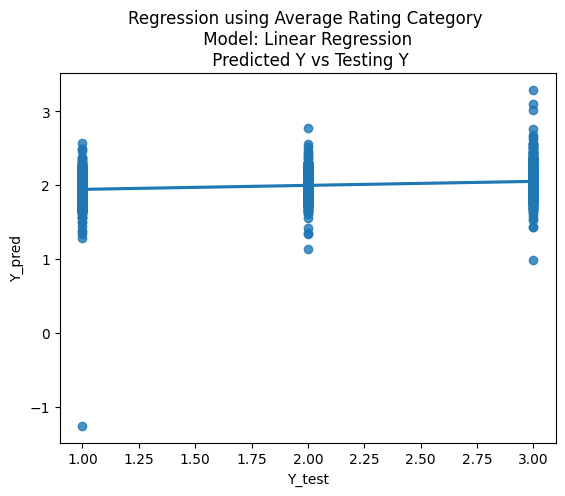

In [58]:
perform_linear_regression(regression_dataset_avg_rating_cat_dict['X_train'],regression_dataset_avg_rating_cat_dict['Y_train'],regression_dataset_avg_rating_cat_dict['X_test'], regression_dataset_avg_rating_cat_dict['Y_test'],regression_dataset_avg_rating_cat_dict['name'])

Coefficients: 
 [ 1.34851644e+00 -1.33413630e+00  7.28918384e-02 -4.94149130e-03
  1.91866103e-04  5.48979091e-03 -2.00973838e-02 -4.48387808e-03
  1.90914710e-02]
Mean squared error: 0.08
Coefficient of determination: 0.06
3.8537844452881695


,Coefficient
log_ratings_count,1.348516
log_total_reviews,-1.334136
multiple_authors,0.072892
n_authors,-0.004941
max_pages,0.000192
season_num_1,0.005490
season_num_2,-0.020097
season_num_3,-0.004484
season_num_4,0.019091


{'model': LinearRegression(),
 'Y_pred': array([3.94064578, 3.89126824, 3.98388556, ..., 3.86648777, 3.89278853,
        3.84715645]),
 'Coefficients_dataset':                    Coefficient
 log_ratings_count     1.348516
 log_total_reviews    -1.334136
 multiple_authors      0.072892
 n_authors            -0.004941
 max_pages             0.000192
 season_num_1          0.005490
 season_num_2         -0.020097
 season_num_3         -0.004484
 season_num_4          0.019091}

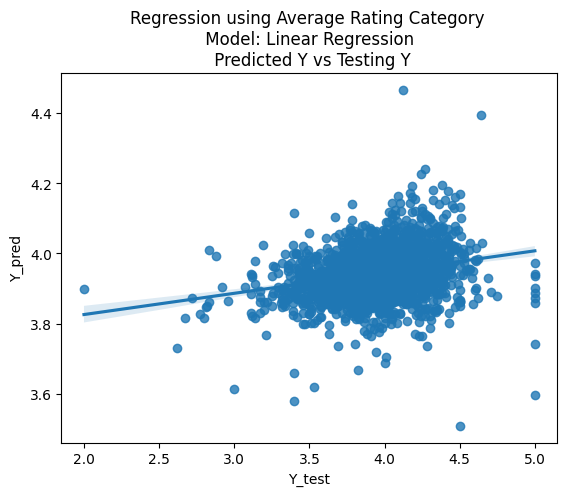

In [59]:
perform_linear_regression(regression_dataset_avg_rating_dict['X_train'],regression_dataset_avg_rating_dict['Y_train'],regression_dataset_avg_rating_dict['X_test'], regression_dataset_avg_rating_dict['Y_test'],regression_dataset_avg_rating_dict['name'])

Coefficients: 
 [ 2.92682464e+00 -2.89664274e+00  2.06555201e-01 -7.29233021e-03
  4.60145164e-04  1.78327437e+00  1.72549166e+00  1.74870805e+00
  1.80258061e+00]
Mean squared error: 0.64
Coefficient of determination: 0.05
0.0


,Coefficient
log_ratings_count,2.926825
log_total_reviews,-2.896643
multiple_authors,0.206555
n_authors,-0.007292
max_pages,0.000460
season_num_1,1.783274
season_num_2,1.725492
season_num_3,1.748708
season_num_4,1.802581


{'model': BayesianRidge(compute_score=True, fit_intercept=False, tol=1e-06),
 'Y_pred': array([2.07617242, 1.92225438, 1.96975158, ..., 2.14756346, 1.92006045,
        1.91744622]),
 'Coefficients_dataset':                    Coefficient
 log_ratings_count     2.926825
 log_total_reviews    -2.896643
 multiple_authors      0.206555
 n_authors            -0.007292
 max_pages             0.000460
 season_num_1          1.783274
 season_num_2          1.725492
 season_num_3          1.748708
 season_num_4          1.802581}

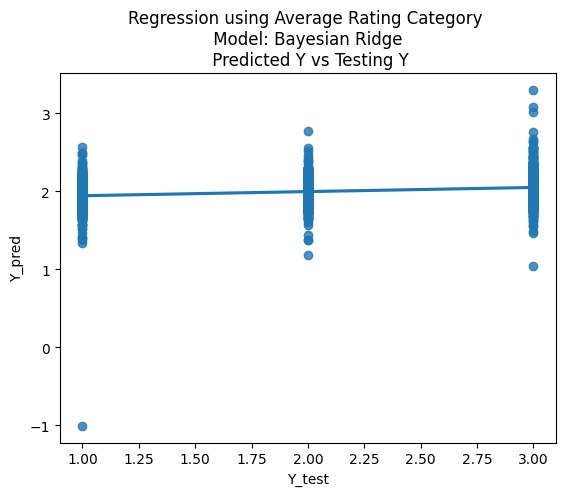

In [60]:
from sklearn.linear_model import BayesianRidge

reg = BayesianRidge(tol=1e-6, fit_intercept=False, compute_score=True)
perform_linear_regression(regression_dataset_avg_rating_cat_dict['X_train'],regression_dataset_avg_rating_cat_dict['Y_train'],regression_dataset_avg_rating_cat_dict['X_test'], regression_dataset_avg_rating_cat_dict['Y_test'],regression_dataset_avg_rating_cat_dict['name'], model_name='Bayesian Ridge',model=reg)


Coefficients: 
 [ 1.34131144e+00 -1.32683305e+00  7.29387543e-02 -4.93199040e-03
  1.92010191e-04  3.85866446e+00  3.83307114e+00  3.84868906e+00
  3.87225643e+00]
Mean squared error: 0.08
Coefficient of determination: 0.06
0.0


,Coefficient
log_ratings_count,1.341311
log_total_reviews,-1.326833
multiple_authors,0.072939
n_authors,-0.004932
max_pages,0.000192
season_num_1,3.858664
season_num_2,3.833071
season_num_3,3.848689
season_num_4,3.872256


{'model': BayesianRidge(compute_score=True, fit_intercept=False, tol=1e-06),
 'Y_pred': array([3.94039881, 3.89127449, 3.98392425, ..., 3.86635312, 3.89282385,
        3.84709349]),
 'Coefficients_dataset':                    Coefficient
 log_ratings_count     1.341311
 log_total_reviews    -1.326833
 multiple_authors      0.072939
 n_authors            -0.004932
 max_pages             0.000192
 season_num_1          3.858664
 season_num_2          3.833071
 season_num_3          3.848689
 season_num_4          3.872256}

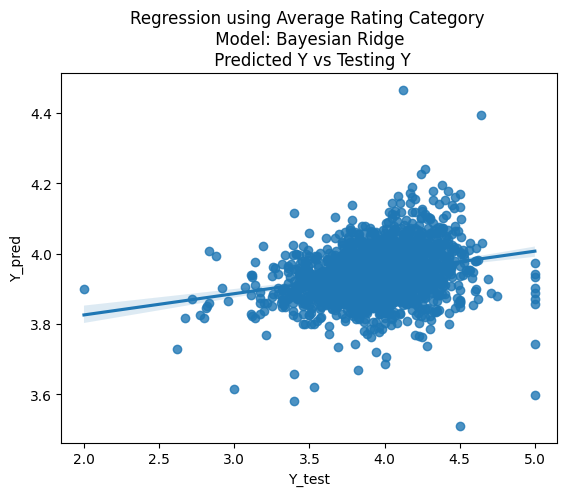

In [61]:
perform_linear_regression(regression_dataset_avg_rating_dict['X_train'],regression_dataset_avg_rating_dict['Y_train'],regression_dataset_avg_rating_dict['X_test'], regression_dataset_avg_rating_dict['Y_test'],regression_dataset_avg_rating_dict['name'], model_name='Bayesian Ridge',model=reg)

## Classification
3. Random Forest
4. AdaBoost


In [ ]:

feature_engineered_regression_columns=['average_rating','log_ratings_count', 'log_text_reviews_count_updt', 'log_total_reviews','multiple_authors', 'n_authors', 'max_pages', 
       'pub_month', 'pub_year',
       'season_num','average_rating_cat_T']

feature_engineered_classification_columns=['log_ratings_count', 'log_text_reviews_count_updt', 'log_total_reviews','multiple_authors', 
       'pub_year','season_num','genre_T',
       'max_pages_cat_T', 'average_rating_cat_T']
cleaned_data.head()
regression_dataset = cleaned_data[feature_engineered_regression_columns]
classification_dataset = cleaned_data[feature_engineered_classification_columns]
display(regression_dataset.head())
display(classification_dataset.head())

In [302]:
classification_dataset = pd.read_excel('Projet Python simulations.xlsx',sheet_name="Python_Dataset")

In [39]:
"""merged_data = pd.merge(ori_data, cleaned_data, how="inner", on=["isbn"])
merged_data.columns
classification_cols = ['rating_category','num_pages_cat', 'ratings_count_cat', 'text_reviews_count_cat','Season', 'Year']"""

In [303]:
classification_dataset.columns

Index(['title', 'Rating_type', 'num_pages_cat', 'ratings_count_cat',
       'text_reviews_count_cat', 'Season', 'Year', 'Publisher_number',
       'Main_Author', 'Author_average', 'average_rating', 'num_pages',
       'rating_count', 'text_reviews_counts', 'genre_T'],
      dtype='object')

In [306]:
feature_engineered_classification_columns=['Rating_type', 'num_pages_cat','ratings_count_cat', 
       'text_reviews_count_cat','Season','Year', 'Author_average','genre_T']
cleaned_data.head()

classification_dataset = classification_dataset[feature_engineered_classification_columns]

display(classification_dataset.head())

,Rating_type,num_pages_cat,ratings_count_cat,text_reviews_count_cat,Season,Year,Author_average,genre_T
0,2,3,3,3,4,2006,1,56872.0
1,3,2,3,3,3,2002,3,56872.0
2,2,2,3,3,1,2001,2,89855.0
3,2,3,3,3,2,2006,2,9302.0
4,3,3,3,3,2,2004,3,56872.0


In [308]:
classification_dataset.columns

Index(['Rating_type', 'num_pages_cat', 'ratings_count_cat',
       'text_reviews_count_cat', 'Season', 'Year', 'Author_average',
       'genre_T'],
      dtype='object')

In [323]:
def from_categoric_to_dummies(columns,dataset):
    dummies = []
    for col in columns:
        dummies.append(pd.get_dummies(dataset[col], prefix=col, prefix_sep='_'))
    return pd.concat([dataset, *dummies], axis=1)

In [316]:
classification_dataset = classification_dataset[~(classification_dataset['genre_T'].isna())]
classification_dataset['genre_T'] = classification_dataset['genre_T'].astype(int)

C:\Users\diego\AppData\Local\Temp\ipykernel_3148\1866114995.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classification_dataset['genre_T'] = classification_dataset['genre_T'].astype(int)


In [317]:
classification_dataset

,Rating_type,num_pages_cat,ratings_count_cat,text_reviews_count_cat,Season,Year,Author_average,genre_T
0,2,3,3,3,4,2006,1,56872
1,3,2,3,3,3,2002,3,56872
2,2,2,3,3,1,2001,2,89855
3,2,3,3,3,2,2006,2,9302
4,3,3,3,3,2,2004,3,56872
...,...,...,...,...,...,...,...,...
10285,3,2,1,1,1,1994,2,9302
10286,2,3,1,1,1,1988,2,58498
10287,3,1,1,1,2,2006,2,58498
10288,2,1,1,1,4,2002,2,28218


In [325]:
classification_dataset_ready = from_categoric_to_dummies(['num_pages_cat','ratings_count_cat','text_reviews_count_cat','Season','genre_T'],classification_dataset)

In [326]:
X = classification_dataset_ready.drop(['Rating_type'], axis=1)
Y= classification_dataset_ready.Rating_type.values

In [44]:
dfc_train.columns

Index(['rating_category', 'Year', 'np_cat_1', 'np_cat_2', 'np_cat_3',
       'rcount_cat_1', 'rcount_cat_2', 'rcount_cat_3', 'tr_count_1',
       'tr_count_2', 'tr_count_3', 'season_1', 'season_2', 'season_3',
       'season_4'],
      dtype='object')

In [355]:
from sklearn.datasets import make_classification
#from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


"""# generate sample dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=0, random_state=42)"""

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# define and train models
#lr_model = LogisticRegression(random_state=42).fit(X_train, y_train)
rf_model = RandomForestClassifier(random_state=42).fit(X_train, y_train)
svm_model = SVC(random_state=42).fit(X_train, y_train)
ab_model = AdaBoostClassifier(random_state=42).fit(X_train, y_train)

# make predictions
ab_preds = ab_model.predict(X_test)
rf_preds = rf_model.predict(X_test)
svm_preds = svm_model.predict(X_test)


"""from sklearn.metrics import confusion_matrix
cf = pd.DataFrame(
    columns=["y_test_0","y_test_1","y_test_2"],index=["y_pred_0","y_pred_1","y_pred_2"]
)
cf.loc[:,:] = confusion_matrix(y_true= Y_test,y_pred= y_test_pred)
cf
cf/len(Y_test)
"""

# compute performance metrics
def print_metrics(y_true, y_pred):
    """acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print("Accuracy:", acc)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)"""
    cf = pd.DataFrame(
    columns=["y_test_1","y_test_2","y_test_3"],index=["y_test_1","y_test_2","y_test_3"])
    cf.loc[:,:] = confusion_matrix(y_true= y_true,y_pred= y_pred)
    print(cf/len(y_true))
    """print(cf/len(y_true))"""
    report =classification_report(y_true=y_true, y_pred=y_pred)
    print(report)


#print("Logistic Regression Metrics:")
print_metrics(y_test, ab_preds)

print("Random Forest Metrics:")
print_metrics(y_test, rf_preds)

print("SVM Metrics:")
print_metrics(y_test, svm_preds)


         y_test_1 y_test_2 y_test_3
y_test_1      140      107        0
y_test_2       71     1992       45
y_test_3        3      355      372
              precision    recall  f1-score   support

           1       0.65      0.57      0.61       247
           2       0.81      0.94      0.87      2108
           3       0.89      0.51      0.65       730

    accuracy                           0.81      3085
   macro avg       0.79      0.67      0.71      3085
weighted avg       0.82      0.81      0.80      3085

Random Forest Metrics:
         y_test_1 y_test_2 y_test_3
y_test_1       95      144        8
y_test_2       94     1769      245
y_test_3       10      312      408
              precision    recall  f1-score   support

           1       0.48      0.38      0.43       247
           2       0.80      0.84      0.82      2108
           3       0.62      0.56      0.59       730

    accuracy                           0.74      3085
   macro avg       0.63      0.59   

c:\Users\diego\anaconda3\envs\BookML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\diego\anaconda3\envs\BookML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\diego\anaconda3\envs\BookML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [353]:
# decision tree  on imbalanced dataset with SMOTE oversampling and random undersampling
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# define dataset
"""X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)"""
# define pipeline
model = RandomForestClassifier()
over = SMOTE(sampling_strategy="auto")
under = RandomUnderSampler(sampling_strategy="auto")
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, Y, cv=cv, n_jobs=-1, error_score="raise", verbose=1)
print('Mean ROC AUC: %.3f' % mean(scores))
k_values = [1, 2, 3, 4, 5, 6, 7]
for k in k_values:
	# define pipeline
	model = AdaBoostClassifier()
	over = SMOTE(sampling_strategy="auto", k_neighbors=k)
	under = RandomUnderSampler(sampling_strategy="auto")
	steps = [('over', over), ('under', under), ('model', model)]
	pipeline = Pipeline(steps=steps)
	# evaluate pipeline
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(pipeline, X, Y, cv=cv, n_jobs=-1, error_score="raise", verbose=1)
	score = mean(scores)
	print('> k=%d, Mean ROC AUC: %.3f' % (k, score))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Mean ROC AUC: 0.715


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


> k=1, Mean ROC AUC: 0.743


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


> k=2, Mean ROC AUC: 0.747


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


> k=3, Mean ROC AUC: 0.754


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


> k=4, Mean ROC AUC: 0.765


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


> k=5, Mean ROC AUC: 0.767


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


> k=6, Mean ROC AUC: 0.774
> k=7, Mean ROC AUC: 0.774


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.0s finished


In [338]:
scores

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan])

In [352]:
# decision tree evaluated on imbalanced dataset
from numpy import mean
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
# define dataset
"""X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)"""
# define model
model = AdaBoostClassifier()
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X, Y, cv=cv, n_jobs=-1,error_score="raise", verbose=1)
print('Mean ROC AUC: %.3f' % mean(scores))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Mean ROC AUC: 0.802


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.0s finished


In [334]:
scores

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan])

In [296]:
# decision tree evaluated on imbalanced dataset
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
# define dataset
"""X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)"""
# define model
model = DecisionTreeClassifier()
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X, Y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

c:\Users\diego\anaconda3\envs\BookML\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\diego\anaconda3\envs\BookML\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\diego\anaconda3\envs\BookML\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Mean ROC AUC: nan


In [43]:
from sklearn.model_selection import train_test_split
dfc_train, dfc_test = train_test_split(feature_eng_class_df,test_size = 0.2)
display(len(featured_eng_dataset))
display(len(dfc_train))
display(len(dfc_test))

10311

8248

2063

In [45]:
# get the values of the columns for the training data
X_train = dfc_train.loc[:,['Year', 'np_cat_1', 'np_cat_2', 'np_cat_3',
       'rcount_cat_1', 'rcount_cat_2', 'rcount_cat_3', 'tr_count_1',
       'tr_count_2', 'tr_count_3', 'season_1', 'season_2', 'season_3',
       'season_4']].values
Y_train = dfc_train.rating_category.values

# get the values of the columns for the test data
X_test = dfc_test.loc[:,['Year', 'np_cat_1', 'np_cat_2', 'np_cat_3',
       'rcount_cat_1', 'rcount_cat_2', 'rcount_cat_3', 'tr_count_1',
       'tr_count_2', 'tr_count_3', 'season_1', 'season_2', 'season_3',
       'season_4']].values
Y_test = dfc_test.rating_category.values

In [298]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
"""X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)"""
gnb = GaussianNB()
y_test_pred = gnb.fit(X_train, Y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (Y_test != y_test_pred).sum()))

ValueError: Unknown label type: (array([1.  , 1.67, 2.  , 2.4 , 2.5 , 2.55, 2.62, 2.63, 2.67, 2.72, 2.75,
       2.77, 2.79, 2.8 , 2.81, 2.82, 2.83, 2.86, 2.88, 2.89, 2.92, 2.93,
       2.94, 2.96, 2.98, 3.  , 3.02, 3.04, 3.06, 3.07, 3.08, 3.09, 3.1 ,
       3.11, 3.12, 3.13, 3.14, 3.15, 3.16, 3.17, 3.18, 3.19, 3.2 , 3.21,
       3.22, 3.23, 3.24, 3.25, 3.26, 3.27, 3.28, 3.29, 3.3 , 3.31, 3.32,
       3.33, 3.34, 3.35, 3.36, 3.37, 3.38, 3.39, 3.4 , 3.41, 3.42, 3.43,
       3.44, 3.45, 3.46, 3.47, 3.48, 3.49, 3.5 , 3.51, 3.52, 3.53, 3.54,
       3.55, 3.56, 3.57, 3.58, 3.59, 3.6 , 3.61, 3.62, 3.63, 3.64, 3.65,
       3.66, 3.67, 3.68, 3.69, 3.7 , 3.71, 3.72, 3.73, 3.74, 3.75, 3.76,
       3.77, 3.78, 3.79, 3.8 , 3.81, 3.82, 3.83, 3.84, 3.85, 3.86, 3.87,
       3.88, 3.89, 3.9 , 3.91, 3.92, 3.93, 3.94, 3.95, 3.96, 3.97, 3.98,
       3.99, 4.  , 4.01, 4.02, 4.03, 4.04, 4.05, 4.06, 4.07, 4.08, 4.09,
       4.1 , 4.11, 4.12, 4.13, 4.14, 4.15, 4.16, 4.17, 4.18, 4.19, 4.2 ,
       4.21, 4.22, 4.23, 4.24, 4.25, 4.26, 4.27, 4.28, 4.29, 4.3 , 4.31,
       4.32, 4.33, 4.34, 4.35, 4.36, 4.37, 4.38, 4.39, 4.4 , 4.41, 4.42,
       4.43, 4.44, 4.45, 4.46, 4.47, 4.48, 4.49, 4.5 , 4.51, 4.52, 4.53,
       4.54, 4.55, 4.56, 4.57, 4.58, 4.59, 4.6 , 4.61, 4.62, 4.63, 4.64,
       4.65, 4.67, 4.69, 4.7 , 4.71, 4.72, 4.73, 4.75, 4.76, 4.78, 4.82,
       4.88, 4.91, 5.  ]),)

In [50]:
from sklearn.metrics import confusion_matrix
cf = pd.DataFrame(
    columns=["y_test_0","y_test_1","y_test_2"],index=["y_pred_0","y_pred_1","y_pred_2"]
)
cf.loc[:,:] = confusion_matrix(y_true= Y_test,y_pred= y_test_pred)
cf
cf/len(Y_test)

In [51]:
cf
cf/len(Y_test)

,y_test_0,y_test_1,y_test_2
y_pred_0,0.022782,0.062046,0.003393
y_pred_1,0.095007,0.55841,0.019874
y_pred_2,0.031023,0.199224,0.00824


In [52]:
from sklearn.metrics import classification_report
report =classification_report(y_true=Y_test, y_pred=y_test_pred)
print(report)

              precision    recall  f1-score   support

           1       0.15      0.26      0.19       182
           2       0.68      0.83      0.75      1389
           3       0.26      0.03      0.06       492

    accuracy                           0.59      2063
   macro avg       0.37      0.37      0.33      2063
weighted avg       0.53      0.59      0.54      2063



In [297]:
# decision tree  on imbalanced dataset with SMOTE oversampling and random undersampling
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# define dataset
"""X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)"""
# define pipeline
model = DecisionTreeClassifier()
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X_train, Y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

ValueError: Found input variables with inconsistent numbers of samples: [7198, 8226]

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
iris = load_iris()
cross_val_score(clf, iris.data, iris.target, cv=10)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=4,
                           n_informative=2, n_redundant=0,
                           random_state=0, shuffle=False)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X, y)

print(clf.predict([[0, 0, 0, 0]]))

In [ ]:
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier

X, y = load_iris(return_X_y=True)
clf = AdaBoostClassifier(n_estimators=100)
scores = cross_val_score(clf, X, y, cv=5)
scores.mean()

In [ ]:
random_forrest.fit(X=X_train_prepared,y=y_train)
adaboost.fit(X=X_train_prepared,y=y_train)
decision_tree.fit(X=X_train_prepared,y=y_train)
linear_regression.fit(X=X_train_prepared,y=y_train)

y_test_pred_random_forrest = random_forrest.predict(X_test_prepared)
y_test_pred_adaboost = adaboost.predict(X_test_prepared)
y_test_pred_decision_tree= decision_tree.predict(X_test_prepared)
y_test_pred_linear_regression = linear_regression.predict(X_test_prepared)

from sklearn.metrics import mean_absolute_error, max_error, explained_variance_score

print("linear_regression")
mean_absolute_error(y_pred=y_test_pred_linear_regression,y_true=y_test)
print("decision_tree")
mean_absolute_error(y_pred=y_test_pred_decision_tree,y_true=y_test)
print("random_forrest")
mean_absolute_error(y_pred=y_test_pred_random_forrest,y_true=y_test)
print("adaboost")
mean_absolute_error(y_pred=y_test_pred_adaboost,y_true=y_test)

## Unsupervised Learning

1. K-means (General-purpose, even cluster size, flat geometry, not too many )
2. DBSCAN (Non-flat Geometry, uneven cluster sizes, outilser removal, transductive)

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
X = np.array([[1, 2], [1, 4], [1, 0],
              [10, 2], [10, 4], [10, 0]])
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(X)
kmeans.labels_

kmeans.predict([[0, 0], [12, 3]])

kmeans.cluster_centers_


In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np
X = np.array([[1, 2], [2, 2], [2, 3],
              [8, 7], [8, 8], [25, 80]])
clustering = DBSCAN(eps=3, min_samples=2).fit(X)
clustering.labels_

clustering


In [53]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, Y_train)
clf.predict(X_test[:2, :])
y_pred = clf.predict(X_test)
print(y_pred.dtype)
print(Y_test.dtype)

score = clf.score(X_test, Y_test) # accuracy of the model
print(score)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, y_pred)

int64
int64
0.6732913233155599


In [ ]:
<img src="cm.png" style="width:500px;height:300;">

In [55]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes, ax,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print(cm)
    print('')

    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.sca(ax)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

[[   0  182    0]
 [   0 1389    0]
 [   0  492    0]]



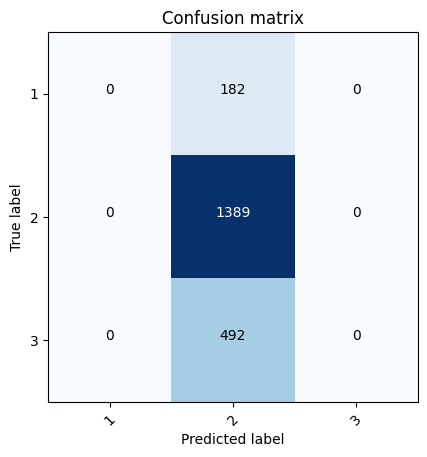

In [57]:
fig, ax = plt.subplots()
plot_confusion_matrix(cm, classes=np.unique(Y_test), ax = ax)

In [54]:
from sklearn.neighbors import (NeighborhoodComponentsAnalysis,
KNeighborsClassifier)
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

nca = NeighborhoodComponentsAnalysis(random_state=42)
knn = KNeighborsClassifier(n_neighbors=4)
nca_pipe = Pipeline([('nca', nca), ('knn', knn)])
nca_pipe.fit(X_train, Y_train)

print(nca_pipe.score(X_test, Y_test))


y_pred_knc = nca_pipe.predict(X_test)
cm_knc = confusion_matrix(Y_test, y_pred_knc)
fig1, ax1 = plt.subplots()
plot_confusion_matrix(cm_knc, classes=np.unique(y), ax = ax1)

KeyboardInterrupt: 

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
"""X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)"""
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
print('Score : ',gnb.score(X_test,y_test))

print(nca_pipe.score(X_test, y_test))


y_pred_gnb = gnb.predict(X_test)
cm_gnb = confusion_matrix(y_test, y_pred_gnb)
fig2, ax2 = plt.subplots()
plot_confusion_matrix(cm_gnb, classes=np.unique(y), ax = ax2)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=2, random_state=0)
r.fit(X_train, y_train)
print(rf.predict(X_test[:2, :]))

In [ ]:
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.inspection import DecisionBoundaryDisplay


"""# import some data to play with
iris = datasets.load_iris()
# Take the first two features. We could avoid this by using a two-dim dataset
X = iris.data[:, :2]
y = iris.target"""

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
models = (
    svm.SVC(kernel="linear", C=C),
    svm.LinearSVC(C=C, max_iter=10000),
    svm.SVC(kernel="rbf", gamma=0.7, C=C),
    svm.SVC(kernel="poly", degree=3, gamma="auto", C=C),
)
models = (clf.fit(X, y) for clf in models)

# title for the plots
titles = (
    "SVC with linear kernel",
    "LinearSVC (linear kernel)",
    "SVC with RBF kernel",
    "SVC with polynomial (degree 3) kernel",
)

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]

for clf, title, ax in zip(models, titles, sub.flatten()):
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.8,
        ax=ax,
        xlabel=iris.feature_names[0],
        ylabel=iris.feature_names[1],
    )
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()

In [ ]:
accuracy : 
    is not the best metric ever,
    there methods that can allow you have better accuracy
    number of corrections / number of 
 
you can change for instance, age can be transform into quality category

Standard Scaler: interesting for preprocessing

You can resample your dataset, there is a resample method in scikit learn to overrepresent, underrepresent

we can perform a pipeline to define 5 to 10 algorithms to test on the same data transformation (sklearn.pipeline.Pipeline)
Depending on the data distribution there are algorithms that could work better

Extra test on ranges

Inferential statistics allows you to see which parameters allow you see which parameters is of value

During Training => you use work on parameters to choose and the robusteness
Then Inference allows you feedback loops => ML Ops

In [ ]:
from sklearn.metrics import confusion_matrix
cf = pd.DataFrame(
    columns=["y_test_0","y_test_1"],index=["y_pred_0","y_pred_1"]
)
cf.loc[:,:] = confusion_matrix(y_true= y_test,y_pred= y_test_predicted)
cf
cf/len(y_test)

In [ ]:
from sklearn.metrics import recall_score, precision_score
recall_score(y_true=y_test, y_pred=y_test_predicted)
precision_score(y_true=y_test, y_pred=y_test_predicted)

In [ ]:
from sklearn.metrics import classification_report
report =classification_report(y_true=y_test, y_pred=y_test_predicted)
print(report)

In [ ]:
from sklearn.neural_network import MLPClassifier
nn_model.fit(X=X_train,y=y_train)
y_test_predicted_nn = nn_model.predict(X_test)
report_nn = classification_report(y_pred=y_test_predicted_nn,y_true=y_test)
print(report_nn)